## PSF Photometry using PAL5 example data

This notebook attempts to implement PSF photometry on the PAL 5 data prior to extending this to all 12 epochs of the data. It starts by using the data to build an effective PSF model, before performing the actual PSF photometry process. 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

In [2]:
image = 'PAL5_data\PAL5_3p6um.fits'

header_list = fits.open(image)
header = header_list[0].header

# assigning values from FITS header for conversion
fluxconv = header['FLUXCONV']
exptime = header['EXPTIME']
print(fluxconv, exptime)
header_list.close()

# retrieve data from image file
image_data = fits.getdata(image, ext = 0)

# convert image data from flux into counts
conv_data = image_data * exptime / fluxconv

0.1469 969.101928711


Now that the data is loaded in and converted into counts, it is necessary to detect the stars for use in building the ePSF model. This will attempt to use the brightest stars in the image and obtain their locations so that we can cut them out to obtain our ePSF.

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1302.2448048834815 ... 1.7184018216890997  -0.5878118110453724
  2 1151.8189707561805 ... 3.2174028988666006  -1.2687636219459033
  3  598.4926539142234 ...  1.488440621146974  -0.4318287846879862
  4  388.3068511578629 ... 16.493531817885685   -3.043284156513189
  5 434.63537984761507 ...  3.768797565811346  -1.4405070268210374
  6 1344.7003392790057 ...  5.449216939217817  -1.8408352449528629
  7  655.5265227504672 ... 1.5242200485538058 -0.45761917435608535
  8   1134.41523945131 ... 2.2053786933596555  -0.8587079361142227
  9 1289.7630234635367 ... 15.459737551807102  -2.9730052923953787
 10  90.16284766561176 ... 1.2286290964908335  -0.2235519902534688
...                ... ...                ...                  ...
243  378.9072921901235 ...  4.842700928688211  -1.7127191227345673
244  392.9716582388227 ...  55.59322437523472   -4.36255465900

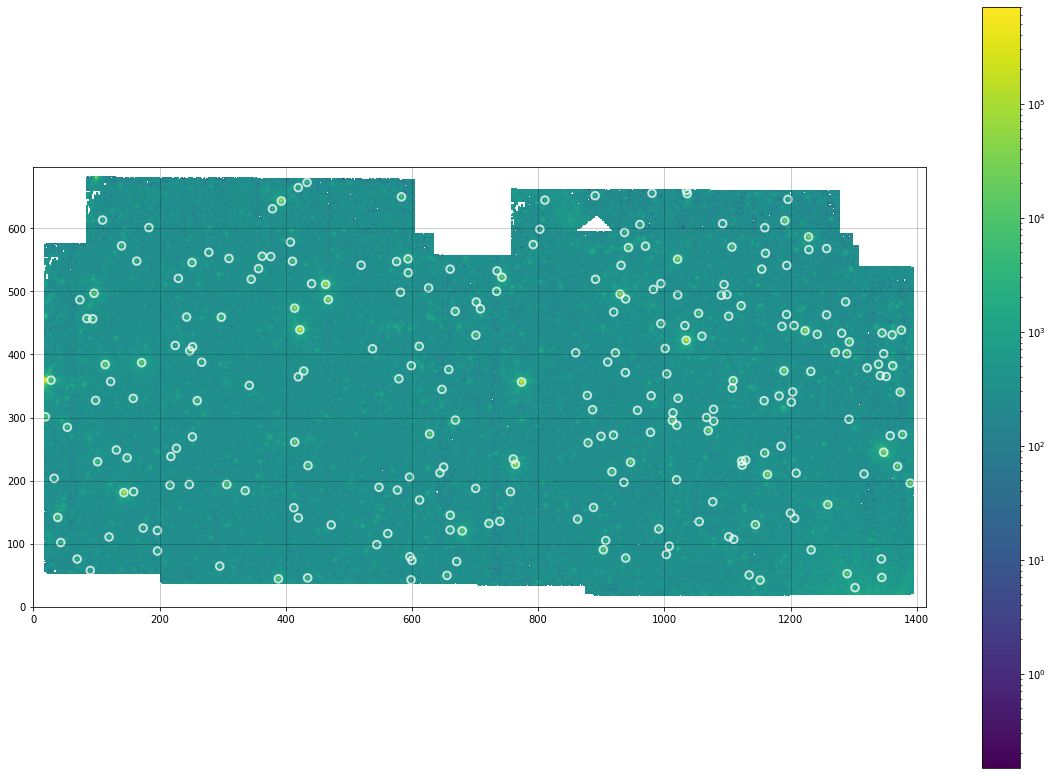

In [3]:
# reassign conv_data to data
data = conv_data

# perform sigma clipping for use in source detection
mean, median, std = sigma_clipped_stats(data, sigma = 5.)

# source detection
daofind = DAOStarFinder(fwhm = 3.0, threshold = 15. * std)
sources = daofind(data - median)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
plt.colorbar()
apertures.plot(color = 'white', lw = 2., alpha = .75)
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(20, 14)

print(sources)

Now extract cut outs of the stars and display a sample of them:

In [4]:
cutout_size = 200
hsize = (cutout_size - 1) / 2
x = sources['xcentroid']
y = sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# create a table of star positions
star_tbl = Table()
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]

print(star_tbl)

        x                  y         
------------------ ------------------
  907.105144411343 105.09550971122708
 1110.003744508116 107.06966681844952
119.91833609506078 110.75484296621552
1102.1788692845316 111.07348328718265
  561.643022567708 116.17555314961962
 679.5936917841985 120.40265244202854
 196.4736743622442 121.04237479615554
 660.4385157423706 121.96246301109063
 991.1379099007984 123.49250853986221
174.00393904503383  124.8374974613831
               ...                ...
 278.0580487806616  561.8609307232753
1229.0895941065617  566.1818611612541
 1257.129990766308  567.8779016781574
 943.1344070227991  569.3874182592101
1107.1256271037291  570.3060528942858
139.73495012946876  572.1907906367493
 970.0345714593191  571.6906159196647
 792.1432909195038  574.1548943464418
407.35501211412077  578.0912589543142
1228.6173920869412   586.325960549796
 936.8597885848159  593.2961313664248
Length = 185 rows


Visual check to ensure stars close to the edge of image frame have indeed been cut out:

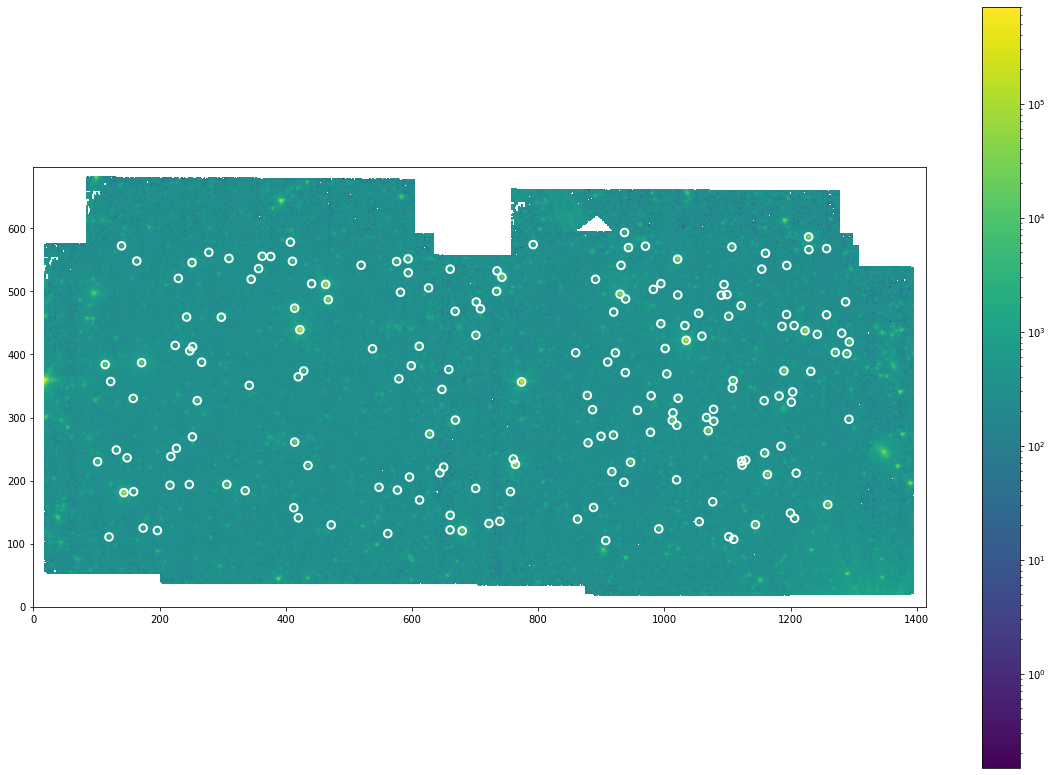

In [5]:
cutpos = np.transpose((star_tbl['x'], star_tbl['y']))
cutaper = CircularAperture(cutpos, r = 6.)

plt.imshow(data, norm = LogNorm(), cmap = 'viridis', origin = 'lower', interpolation = 'nearest')
plt.colorbar()
cutaper.plot(color = 'white', lw = 2.)
plt.gcf().set_size_inches(20, 14)

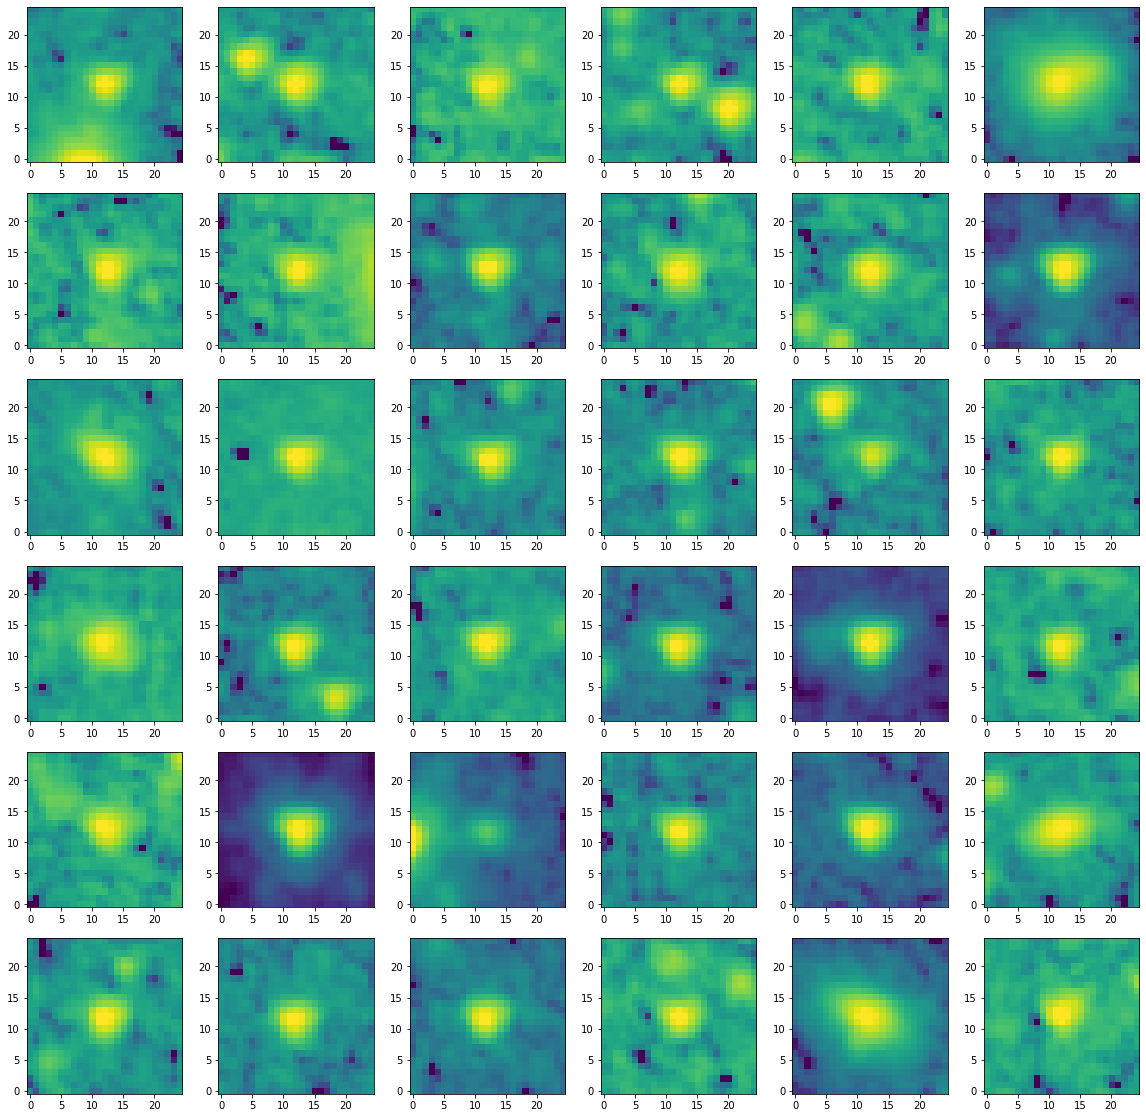

In [6]:
# subtract background from the image using sigma clipping
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = 5.)
data = data - median_val

# extract_stars() requires input data as an NDData object
from astropy.nddata import NDData
nddata = NDData(data = data)

from photutils.psf import extract_stars
stars = extract_stars(nddata, star_tbl, size = 25)

# show the first 25 of extracted stars
nrows = 6
ncols = 6
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)

ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], norm = norm, origin = 'lower', cmap = 'viridis')

It is now time to build the ePSF using the EPSFBuilder class, this will use 3 iterations for now, but can be run for more for future data.

Initialising an EPSFBuilder instance first:

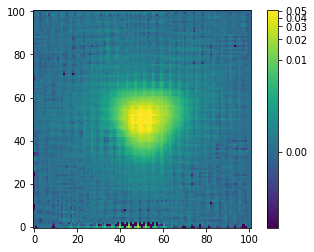

In [7]:
from photutils import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling = 4, maxiters = 3, progress_bar = False)

epsf, fitted_stars = epsf_builder(stars)

# visualise contructed ePSF
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm = norm, origin = 'lower', cmap = 'viridis')
plt.colorbar()

### PSF Photometry

In [14]:
# source detection on original image
psf_daofind = DAOStarFinder(fwhm = 3., threshold = 4. * std)
psf_sources = psf_daofind(conv_data - median)

# rename columns to x_0, y_0 for DAOGroup
psf_sources['xcentroid'].name = 'x_0'
psf_sources['ycentroid'].name = 'y_0'

# DAOGroup
sigma_psf = 4. # sigma value
fwhm = 3. # FWHM
daogroup = DAOGroup(sigma_psf * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

# modify NaNs in data for PSF_photometry
data_psf = np.nan_to_num(conv_data, nan = 0.00001) # converstion btwn mag and counts for this number

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = bkg_estimator,
                                                    psf_model = epsf,
                                                    fitter = fitter,
                                                    niters = 2,
                                                    aperture_radius = 6.,
                                                    fitshape = (11, 11)) #rectangular size around star used to do fitting

result_phot = PSF_photometry(image = data_psf)
residual_image = PSF_photometry.get_residual_image()

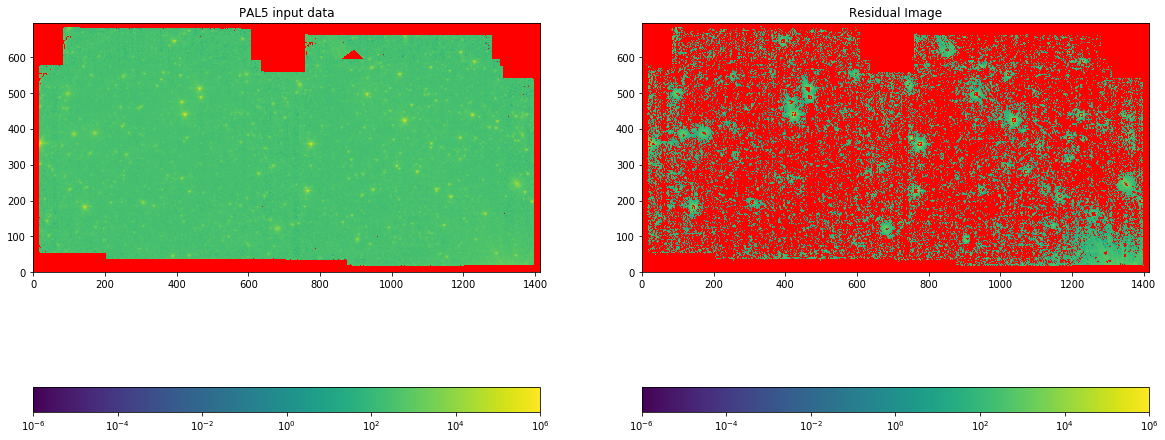

In [15]:
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

plt.subplot(1, 2, 1)
plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('PAL5 input data')
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('Residual Image')
plt.colorbar(orientation='horizontal')

plt.gcf().set_size_inches(20, 14)

In [10]:
# calculation of apparent magnitudes
aper_corr = 1.125      # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
zeropoint_flux = 280.9 # see Reach et al. 2005
zmag = 18.8            # from IRAC handbook §4.8

phot = result_phot                  # redefine photometry table for ease
phot['bkgsub_flux'] = float('NaN')  # populate new column to convert into flux
phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    phot['bkgsub_flux'][i] = phot['flux_0'][i] * fluxconv / exptime
    for i in range(0, len(phot)):
        if phot['bkgsub_flux'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['bkgsub_flux'][i] * aper_corr)

# export into csv file
phot['id', 'x_0', 'y_0', 'apparent_mag'].write(r'C:\Users\lukeb\Documents\MPhys_Project\output_files\psfphot01.txt', format = 'csv', overwrite = True)
           
# format columns
for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])

 id    x_0       y_0      flux_0  apparent_mag
--- --------- --------- --------- ------------
  1 1201.4638  15.79489  11657451    10.553979
  2  1393.462 16.794629  12271176    10.498272
  3  1374.715  21.00836 6064169.6    11.263559
  4 1306.2872 21.691518 5352525.1    11.399091
  7 1302.2448 30.489824 3374321.1    11.900022
  5 1269.2458 28.561557 3309183.2    11.921186
  6 1140.0222 29.913012 3285105.6    11.929115
  8 890.49164  34.44621 3253145.2    11.939729
  9 213.53512 33.799161  11649846    10.554687
 10 615.46622 33.795905  11650518    10.554625
...       ...       ...       ...          ...
104 775.07688 663.04082 8136066.9    10.944452
105 1068.0985 663.72028 8819621.9    10.856863
106 763.18113 664.66188   8688356    10.873144
107 589.09328 679.03775 8114504.3    10.947333
108 492.09808 680.03071 8069673.5    10.953348
109 577.17297 680.65818   8691878    10.872704
110 363.10216 681.05798   8234412    10.931406
111 480.16796 681.65639 8667615.6    10.875739
112 142.10458